# Basic analyses in ECoG or LFP signals

In [38]:
import aopy
import numpy as np
import matplotlib.pyplot as plt
from db import dbfunctions as db
import matplotlib_inline.backend_inline
import multiprocessing as mp
from scipy.signal import filtfilt
import matplotlib.ticker as mticker

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.family'] = 'Arial'

# EVENT CODE
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239
END_TRIAL_CODE = TRIAL_END

## Get a relevant task id

In [2]:
data_dir = '/media/moor-data/raw'
preproc_dir = '/media/moor-data/preprocessed'

subject = 'beignet'
date = (2022,6,28)
entries = db.get_task_entries(subject__name=subject, date=date, task__name='manual control')

for entry in entries:
    params = entry.task_params
    
    # Extract task id relevant with the delayed center out task
    if 'rand_delay' in params:
        exp_id = entry.id
        exp_date = entry.date.date()
        print(entry.report)

print('task id:', exp_id)
print('experiment date:', exp_date)

{"runtime": 2375.984918117523, "n_trials": 915, "n_success_trials": 800}
task id: 5927
experiment date: 2022-06-28


## Load relevant data

In [3]:
trial_filter = lambda t: REWARD in t # choose only rewarded trials for analysis

# Load data
lfp_data, lfp_metadata =  aopy.data.load_preproc_lfp_data(preproc_dir, subject, exp_id, exp_date)
data, metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, exp_id, exp_date)
eye_data, eye_metadata = aopy.data.load_preproc_eye_data(preproc_dir, subject, exp_id, exp_date)
fs = lfp_metadata['lfp_samplerate']
volt_bit = lfp_metadata['voltsperbit']

# Get channels position and acqusition channels
elec_pos, acq_ch, elecs = aopy.data.load_chmap(drive_type='ECoG244')

# Convert int data into voltage
lfp_data = lfp_data[:,acq_ch-1]*volt_bit # Only use channels with acq_ch

# Load event times
segs, times = aopy.preproc.base.get_trial_segments_and_times(data['events']['code'], data['events']['timestamp'],CURSOR_ENTER_CENTER_TARGET, TRIAL_END)
times = [t for s, t in zip(segs, times) if trial_filter(s)]  # get_trial_segments_and_times() does not include a trial filter so doing this outside. 

trial_start = np.array([t[0] for t in times])
target_onset = np.array([t[1] for t in times])
gocue_time = np.array([t[2] for t in times])
acquire_time = np.array([t[3] for t in times]) # corresponds to cursor enter peripheral target 
reward_time = np.array([t[4] for t in times])
trial_end = np.array([t[5] for t in times])
ntr = gocue_time.shape[0]

# Load cursor trajectory
cursor_traj, tsegs = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CURSOR_ENTER_CENTER_TARGET, TRIAL_END, trial_filter=trial_filter) 

# Target labels
target_idx = np.array([int(seg[1] - CENTER_TARGET_ON ) for seg in tsegs])

## Preprocessing

Bad channels : [ 59 228]
The number of bad channels : 2


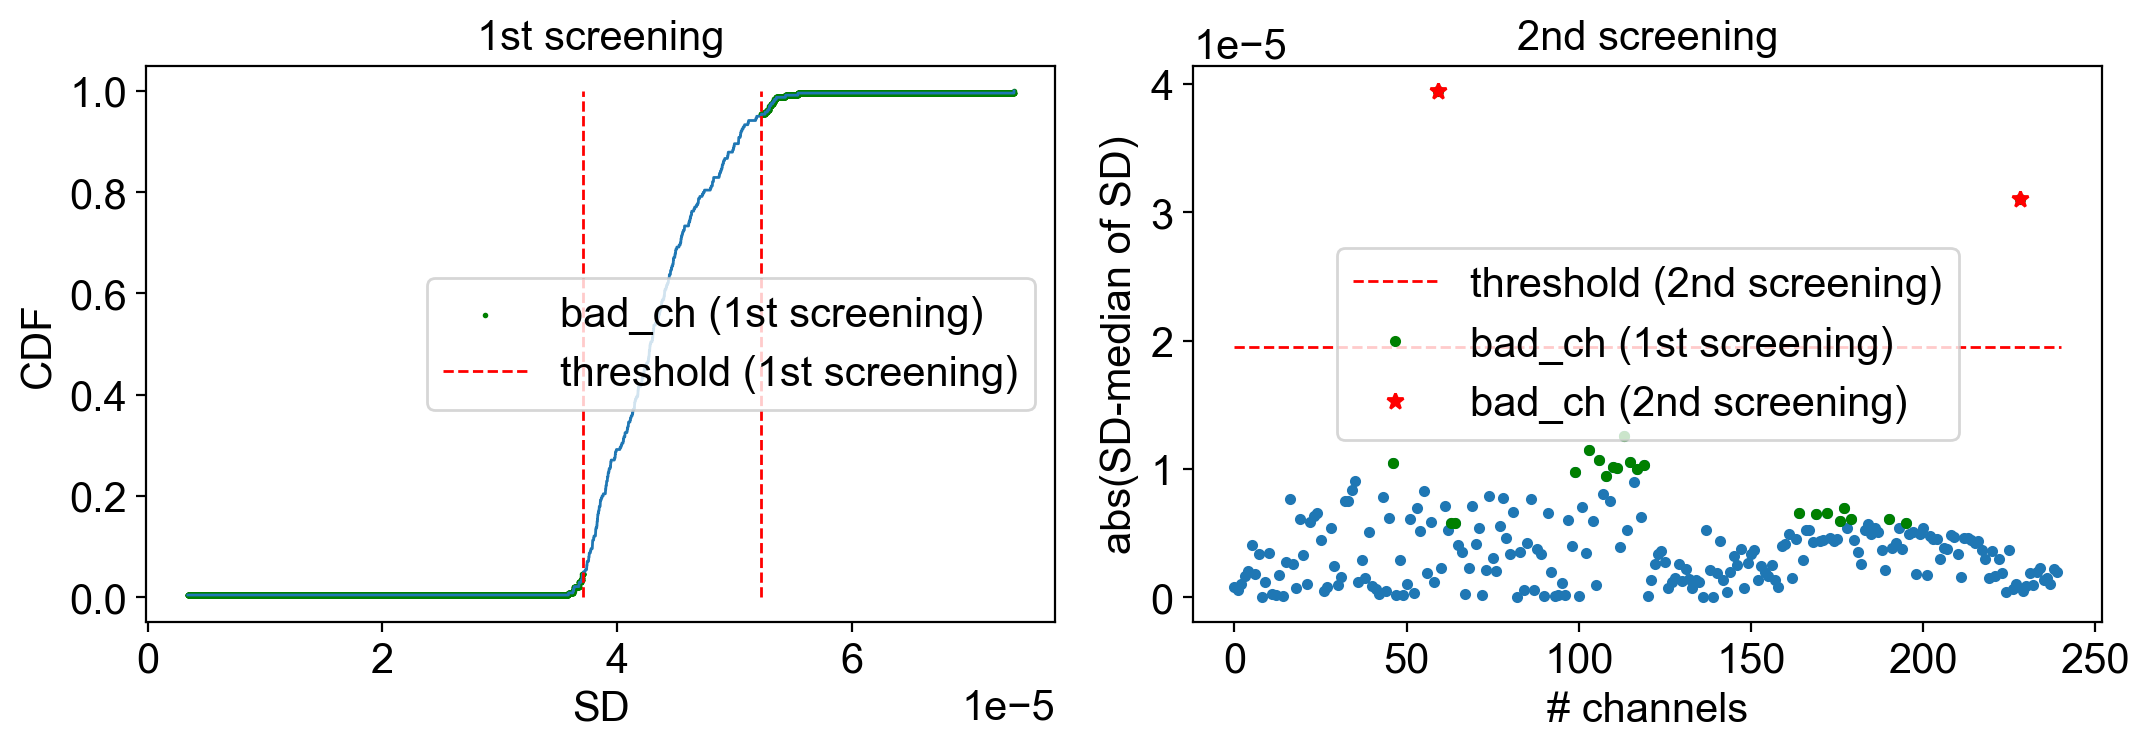

In [4]:
# Bad channel detection
numsd_badch = 5.0
bad_ch = aopy.preproc.quality.detect_bad_ch_outliers(lfp_data[:60*fs,:], nbins=10000, thr=0.05, numsd=numsd_badch, debug=True, verbose=True) #bad channels detected from the lfp data in the 1st second
good_ch = ~bad_ch

# Only use good channel data
elec_pos = elec_pos[good_ch]
acq_ch = acq_ch[good_ch]
lfp_data = lfp_data[:,good_ch]

# Band-pass filter lfp_data to remove DC component. Otherwise, low frequency power is confounded by DC in the subsequent re-referencing process
cutoff_freq = (0.1, 200)
filter_order = 4
b, a = aopy.precondition.butterworth_params(cutoff_freq[0], cutoff_freq[1], fs, order = filter_order, filter_type = 'bandpass')
lfp_filter = filtfilt(b, a, lfp_data, axis=0)

# Re-reference data by subtracting mean across channels from data to localize signals and remove noise shared across channels
lfp_reref = lfp_filter - np.mean(lfp_filter, axis=1, keepdims=True)

# Compute movement onset based on cursor speed
movement_onset = aopy.analysis.get_movement_onset(cursor_traj, 1000, trial_start, target_onset, gocue_time, numsd=3.0, butter_order=4, low_cut=20, thr=5)
movement_onset = movement_onset + trial_start

## Calculate spectral power using multitaper method

In [7]:
# Parameters for multitaper
bands = [(0.1,4),(4,8),(8,14),(14,30),(30,80),(80,150)]
nband = len(bands)
band_name = ['delta','theta','alpha','beta','gamma','hgamma']
nch = lfp_reref.shape[-1]

# Get parameters for multitaper analysis.
NW = 0.5 # time resolution in sec. the length of the time window to extract data. 
BW = 4 # frequency resolution
dn = 0.02 # step size to move the time window
fk = 200 # the upper range of frequency for multitaper method

#### Note ####################################################################################
## Tapers are applied to each windowed data, then FFT is performed to the tapered data.     ##
## When muptiple tapers are used, the spectral power is estimated for each tapered data,    ##
## then averaged across tapers                                                              ##
## The number of taper is determined by (2*NW*BW-1). 3 or 5 tapers are usually used.        ##
## Spectral power gets more smooth as the nubmer of tapers increases.                       ##
## But the large number of tapers may cause weird effects                                   ##
##############################################################################################

# Apply the multitaper method to time-series data
n,p,k = aopy.precondition.convert_taper_parameters(NW,BW)
f_spec, t_spec, spec = aopy.analysis.calc_mt_tfr(lfp_reref, n, p, k, fs, dn, fk, pad=2, ref=False)
t_spec += n/2 # To move the time axis so that the spectrogram bins are aligned to the right edge of each window

# Average spectrogram for delta, theta, alpha, beta, gamma, highgamma
spec_band = np.zeros((t_spec.shape[0], nband, nch))
for iband, freqs in enumerate(bands):
    f_idx = (freqs[0] <= f_spec)*(freqs[1] >= f_spec)
    spec_band[:,iband,:] = np.mean(spec[f_idx,:,:], axis=0)

In [ ]:
# Normalize spectral power along time axis
spec_norm = (spec_band - np.mean(spec_band, axis=0, keepdims=True))/np.std(spec_band, axis=0, keepdims=True)

# Align spec to (event times - NW) so that the spectrogram bins are aligned to the right edge of each window
time_before = 1.0
time_after = 1.0
fs_spec = int(1/dn) # samplingrate is for spectrogram
spec_aligned_target = aopy.preproc.trial_align_data(spec_norm.reshape(t_spec.shape[0],-1), target_onset-NW, time_before, time_after, fs_spec)
spec_aligned_gocue = aopy.preproc.trial_align_data(spec_norm.reshape(t_spec.shape[0],-1), gocue_time-NW, time_before, time_after, fs_spec)
spec_aligned_reach = aopy.preproc.trial_align_data(spec_norm.reshape(t_spec.shape[0],-1), movement_onset-NW, time_before, time_after, fs_spec)
t_axis = np.linspace(-time_before, time_after, spec_aligned_target.shape[0])

# Reshape to (ntime, nband, nch, ntr)
spec_aligned_target = spec_aligned_target.reshape(t_axis.shape[0], nband, nch, -1)
spec_aligned_gocue = spec_aligned_gocue.reshape(t_axis.shape[0], nband, nch, -1)
spec_aligned_reach = spec_aligned_reach.reshape(t_axis.shape[0], nband, nch, -1)

# Trial-average spectral power
ntarget = len(np.unique(target_idx))
m_spec_aligned_target = np.zeros((spec_aligned_target.shape[0], spec_aligned_target.shape[1], spec_aligned_target.shape[2], ntarget))
m_spec_aligned_gocue = np.zeros((spec_aligned_gocue.shape[0], spec_aligned_gocue.shape[1], spec_aligned_gocue.shape[2], ntarget))
m_spec_aligned_reach = np.zeros((spec_aligned_reach.shape[0], spec_aligned_reach.shape[1], spec_aligned_reach.shape[2], ntarget))
for itarget, targ in enumerate(np.unique(target_idx)):
    m_spec_aligned_target[:,:,:,itarget] = np.mean(spec_aligned_target[:,:,:,target_idx==targ],axis=-1)
    m_spec_aligned_gocue[:,:,:,itarget] = np.mean(spec_aligned_gocue[:,:,:,target_idx==targ],axis=-1)
    m_spec_aligned_reach[:,:,:,itarget] = np.mean(spec_aligned_reach[:,:,:,target_idx==targ],axis=-1)

(100, 6, 238, 800)


## Visualization

(-6.0, 6.0, -6.0, 6.0)

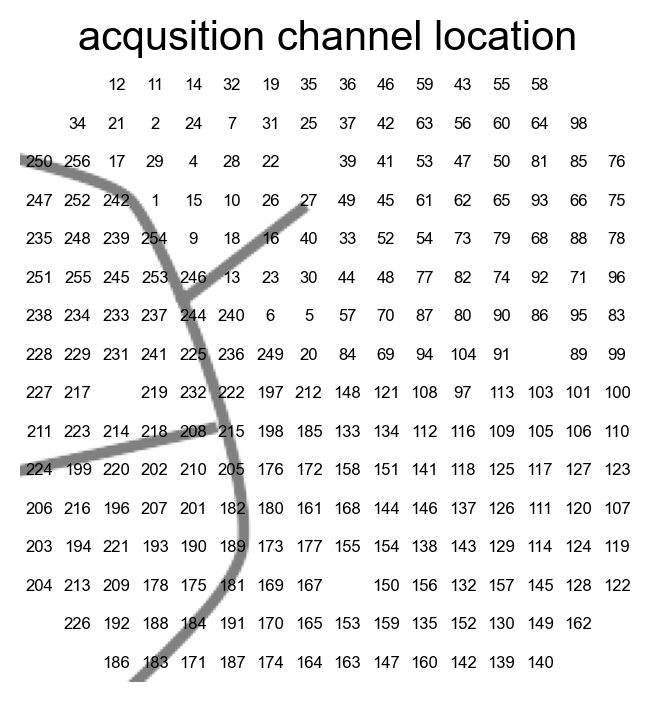

In [10]:
# See channel locations on the brain
fig,ax=plt.subplots(figsize=(4,4))
aopy.visualization.plot_ECoG244_data_map(np.zeros(256,), cmap='Greys',ax=ax)
aopy.visualization.annotate_spatial_map_channels(drive_type='ECoG244', color='k',ax=ax)
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5)
ax.set(title='acqusition channel location')
plt.axis('off')

### Visualize temporal changes in spectral power at exmaple channels

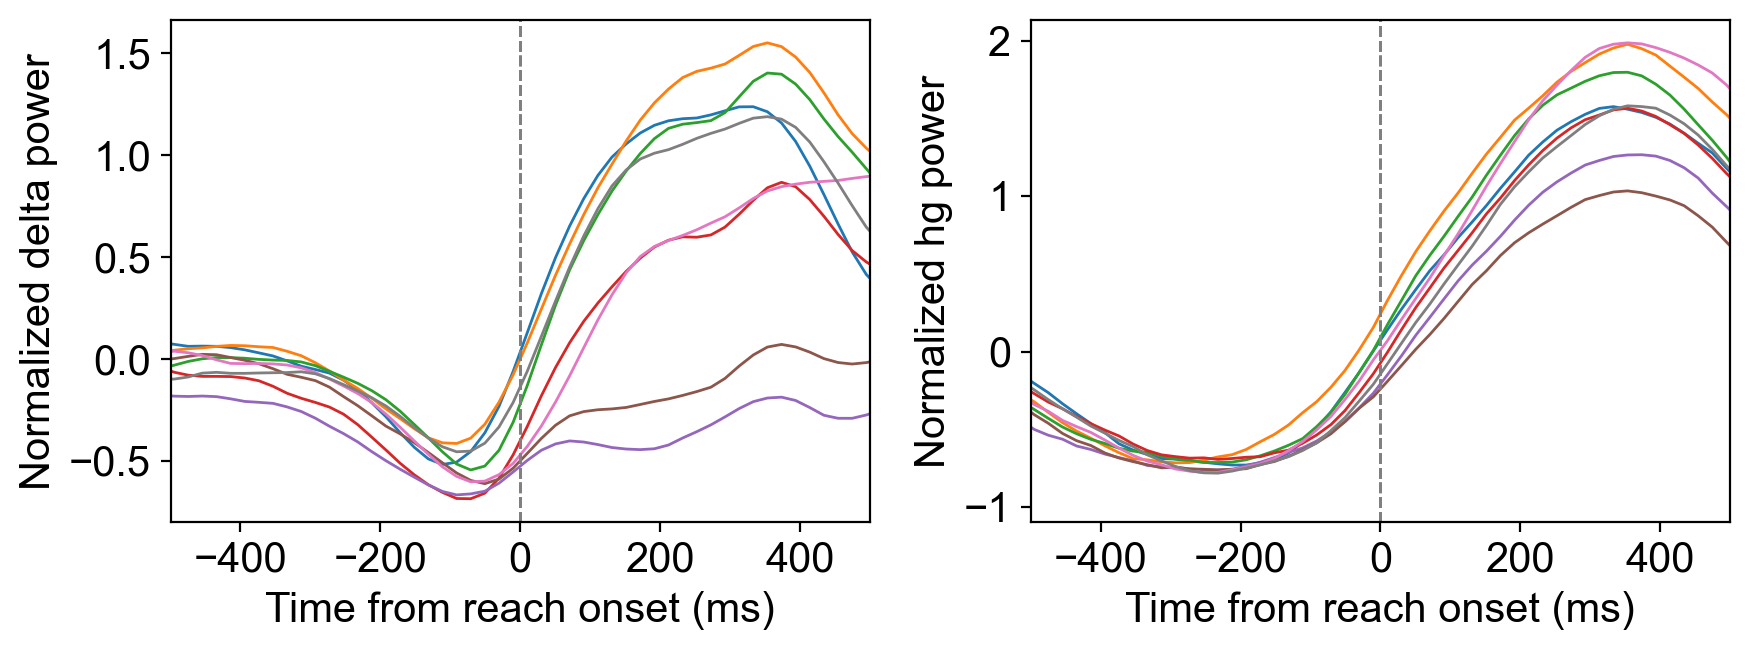

In [11]:
# Choose channels based on the above channel map
ch_list = [76,27,196]

# Note that acq_ch number is different from the matrix index
M1_ch = np.where(acq_ch == ch_list[0])[0][0]
PMd_ch = np.where(acq_ch == ch_list[1])[0][0]
PFC_ch = np.where(acq_ch == ch_list[2])[0][0]

# Plot delta and high gamma power for each movement directions
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3.5), tight_layout=True)
for itarget in range(ntarget):
    ax1.plot(t_axis*1000, m_spec_aligned_reach[:, 0, M1_ch, itarget])
    ax1.axvline(0, color='gray', linestyle='--', label='reach onset')
    ax1.set(xlim=(-500,500), xlabel='Time from reach onset (ms)', ylabel='Normalized delta power')
    
for itarget in range(ntarget):
    ax2.plot(t_axis*1000, m_spec_aligned_reach[:, -1, M1_ch, itarget])
    ax2.axvline(0, color='gray', linestyle='--', label='reach onset')
    ax2.set(xlim=(-500,500), xlabel='Time from reach onset (ms)', ylabel='Normalized hg power')

### Visualize a spatial map about the difference in delta power

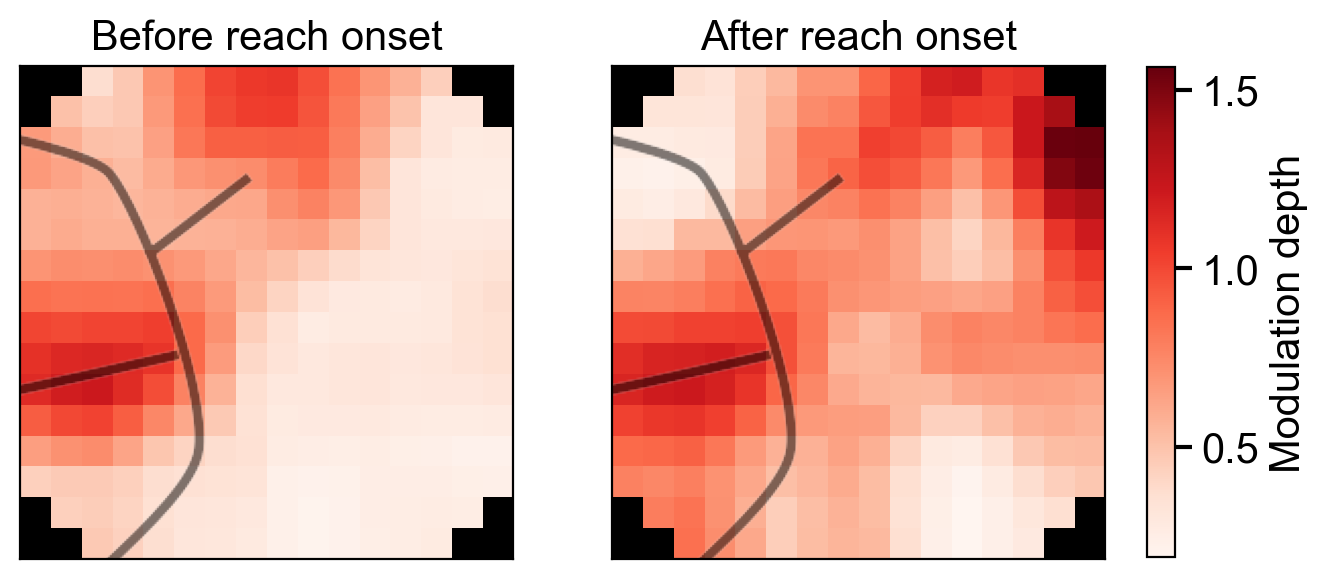

In [12]:
# Compute difference between max delta power and min delta power across reach directions
win_before = (t_axis > -0.3) * (t_axis < -0.2)
win_after = (t_axis > 0.25) * (t_axis < 0.35)
m_delta_before_reach = np.mean(m_spec_aligned_reach[win_before,0,:,:],axis=0)
m_delta_after_reach = np.mean(m_spec_aligned_reach[win_after,0,:,:],axis=0)

# compute the difference between max and min
modulation_depth_before = np.max(m_delta_before_reach, axis=-1) - np.min(m_delta_before_reach, axis=-1)
modulation_depth_after = np.max(m_delta_after_reach, axis=-1) - np.min(m_delta_after_reach, axis=-1)

# Average data acorss neighboring channels
dist = aopy.utils.calc_euclid_dist_mat(elec_pos) # get a distance matrix among all channels
m_modulation_depth_before = np.zeros(nch)*np.nan
m_modulation_depth_after = np.zeros(nch)*np.nan
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3) #0.75, 1.3
    m_modulation_depth_before[ich] = np.nanmean(modulation_depth_before[ave_idx])
    m_modulation_depth_after[ich] = np.nanmean(modulation_depth_after[ave_idx])

# Transform a matrix from 1D to 2D for 2D visualization and interpolate missing channels such as bad channels
md_map_before, pos = aopy.visualization.calc_data_map(m_modulation_depth_before, elec_pos[:,0], elec_pos[:,1], [16, 16])
md_map_after, pos = aopy.visualization.calc_data_map(m_modulation_depth_after, elec_pos[:,0], elec_pos[:,1], [16, 16])

# Apply nan in corner channels
nan_list = [(0,0),(0,1),(1,0),(0,-1),(0,-2),(1,-1),(-1,0),(-1,1),(-2,0),(-1,-1),(-1,-2),(-2,-1)]
for a in nan_list:
    md_map_before[a] = np.nan
    md_map_after[a] = np.nan

# Plot
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(7,3.5))
im1 = aopy.visualization.plot_spatial_map(md_map_before, pos[0], pos[1], ax=ax1, cmap='Reds')
ax1.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[], title='Before reach onset')
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5, ax=ax1)

im2 = aopy.visualization.plot_spatial_map(md_map_after, pos[0], pos[1], ax=ax2, cmap='Reds')
ax2.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[], title='After reach onset')
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5, ax=ax2)

# Set minimum and maximum to use the same range of the color bar
im1.norm.vmin = np.nanmin([md_map_before,md_map_after])
im1.norm.vmax = np.nanmax([md_map_before,md_map_after])
im2.norm.vmin = np.nanmin([md_map_before,md_map_after])
im2.norm.vmax = np.nanmax([md_map_before,md_map_after])

# Make a color bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([.93, 0.145, 0.02, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)
cbar.ax.tick_params(length=6,width=1.5)
cbar.ax.set_ylabel('Modulation depth',fontsize=15)
cbar.update_normal(im2)
fig.show()

## Decoding analysis

In [48]:
# Make trial mask to exclude weird trials
reach_reaction_time = movement_onset - gocue_time
trial_mask = (reach_reaction_time>0.15) * (reach_reaction_time<0.4)

# the minimum number of trials per target to extract trials equally for each target
min_trials = aopy.postproc.get_minimum_trials_per_target(target_idx, trial_mask)

# Average data within time window
win_target = (t_axis>0.1) * (t_axis<0.2)
win = (t_axis>-0.05) * (t_axis<0.05)
data_target_decoding = np.mean(spec_aligned_target[win_target,:,:,:],axis=0).transpose(1,0,2) # shape is (nch, nfeatures, ntr)
data_gocue_decoding = np.mean(spec_aligned_gocue[win,:,:,:],axis=0).transpose(1,0,2)
data_reach_decoding = np.mean(spec_aligned_reach[win,:,:,:],axis=0).transpose(1,0,2) 

In [49]:
import multiprocessing as mp

single_decoding = True
min_unit = None
shuffle_labels = False
n_fold = 5
replacement = False
regularization = 'auto'
lda_model = None
return_labels = True
return_weights = False
n_resample = 300 # the number of resampling
n_processes = 20 # the number of cpus used for the computation

# Decoding of activity at target onset with multiple CPUs
pool = mp.Pool(n_processes)
result_objects = [pool.apply_async(aopy.analysis.xval_lda_subsample_wrapper,args=(data_target_decoding, target_idx, min_trials, trial_mask, single_decoding, min_unit, \
    shuffle_labels, n_fold, replacement, regularization, lda_model, return_labels, return_weights, ibs)) for ibs in range(n_resample)]
pool.close()

# Organize results
results = [r.get() for r in result_objects]
accuracy_target, pred_labels_target, true_labels_target = zip(*results)
accuracy_target = np.array(accuracy_target) # shape is (n_resample, nch)
pred_labels_target = np.array(pred_labels_target, int) # shape is (n_resample, nch, ntest_trial)
true_labels_target = np.array(true_labels_target, int)

# Decoding of activity at go cue with multiple CPUs
pool = mp.Pool(n_processes)
result_objects = [pool.apply_async(aopy.analysis.xval_lda_subsample_wrapper,args=(data_gocue_decoding, target_idx, min_trials, trial_mask, single_decoding, min_unit, \
    shuffle_labels, n_fold, replacement, regularization, lda_model, return_labels, return_weights, ibs)) for ibs in range(n_resample)]
pool.close()

# Organize results
results = [r.get() for r in result_objects]
accuracy_gocue, pred_labels_gocue, true_labels_gocue = zip(*results)
accuracy_gocue = np.array(accuracy_gocue)
pred_labels_gocue = np.array(pred_labels_gocue, int)
true_labels_gocue = np.array(true_labels_gocue, int)

# Decoding of activity at reach onset with multiple CPUs
pool = mp.Pool(n_processes)
result_objects = [pool.apply_async(aopy.analysis.xval_lda_subsample_wrapper,args=(data_reach_decoding, target_idx, min_trials, trial_mask, single_decoding, min_unit, \
    shuffle_labels, n_fold, replacement, regularization, lda_model, return_labels, return_weights, ibs)) for ibs in range(n_resample)]
pool.close()

# Organize results
results = [r.get() for r in result_objects]
accuracy_reach, pred_labels_reach, true_labels_reach = zip(*results)
accuracy_reach = np.array(accuracy_reach)
pred_labels_reach = np.array(pred_labels_reach, int)
true_labels_reach = np.array(true_labels_reach, int)

### Visualize results

In [50]:
# Compute pvalues based on the resampling distribution (compute how many sampling has decoding accuracies less than 1/8)
p_target = np.zeros(nch)*np.nan
p_gocue = np.zeros(nch)*np.nan
p_reach = np.zeros(nch)*np.nan
for ich in range(nch):
    p_target[ich] = np.sum(accuracy_target[:,ich] < 1/ntarget)/n_resample
    p_gocue[ich] = np.sum(accuracy_gocue[:,ich] < 1/ntarget)/n_resample
    p_reach[ich] = np.sum(accuracy_reach[:,ich] < 1/ntarget)/n_resample

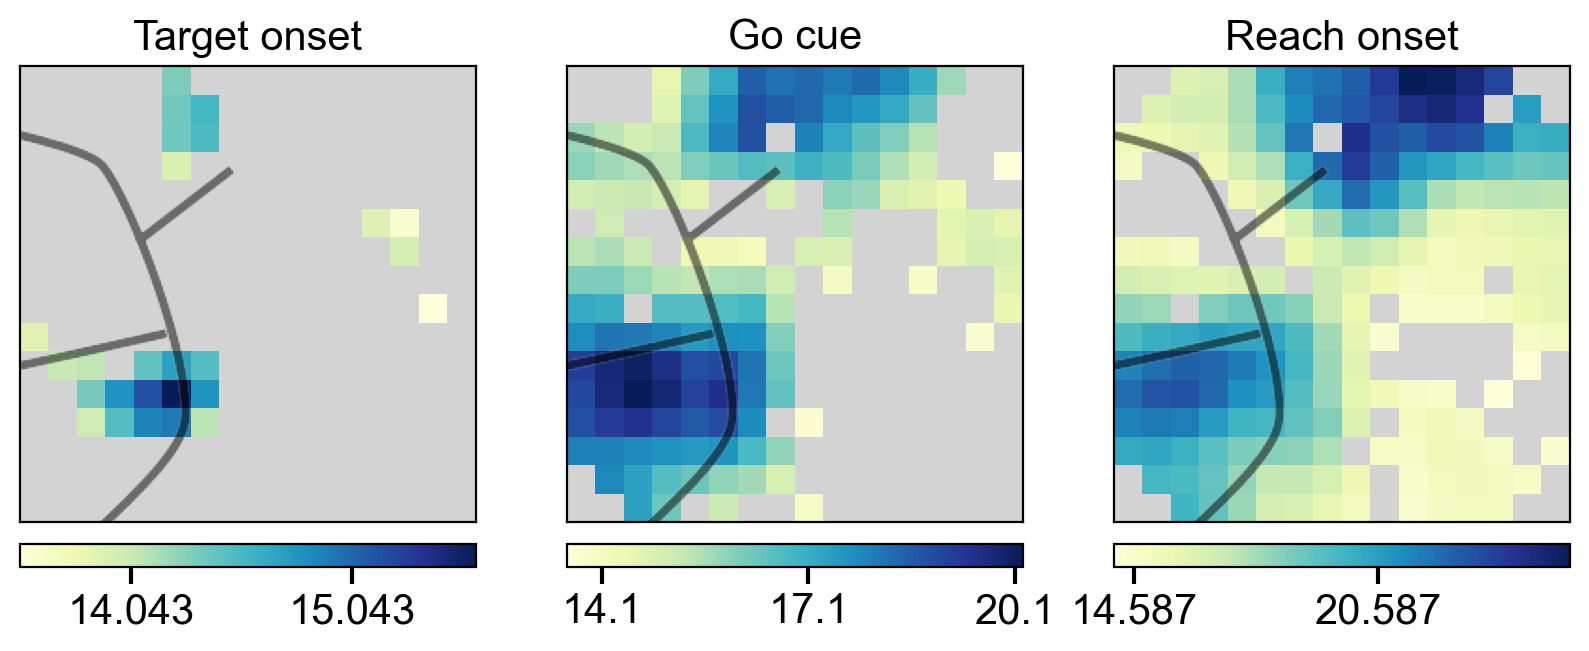

In [ ]:
# Average decoding accuracy across resampling
m_accuracy_target = np.mean(accuracy_target,axis=0)
m_accuracy_gocue = np.mean(accuracy_gocue,axis=0)
m_accuracy_reach = np.mean(accuracy_reach,axis=0)

# Average data acorss neighboring channels
dist = aopy.utils.calc_euclid_dist_mat(elec_pos) # get a distance matrix among all channels
m_accuracy_target_neighbor_ch = np.zeros(nch)*np.nan
m_accuracy_gocue_neighbor_ch = np.zeros(nch)*np.nan
m_accuracy_reach_neighbor_ch = np.zeros(nch)*np.nan
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3) #0.75, 1.3
    m_accuracy_target_neighbor_ch[ich] = np.nanmean(m_accuracy_target[ave_idx])
    m_accuracy_gocue_neighbor_ch[ich] = np.nanmean(m_accuracy_gocue[ave_idx])
    m_accuracy_reach_neighbor_ch[ich] = np.nanmean(m_accuracy_reach[ave_idx])

# Apply nan to not-significant channels
m_accuracy_target_neighbor_ch[p_target > 0.05] = np.nan
m_accuracy_gocue_neighbor_ch[p_gocue > 0.05] = np.nan
m_accuracy_reach_neighbor_ch[p_reach > 0.05] = np.nan

# Transform a matrix from 1D to 2D for 2D visualization and interpolate missing channels such as bad channels
accuracy_target_map = aopy.visualization.get_data_map(m_accuracy_target_neighbor_ch, elec_pos[:,0], elec_pos[:,1])
accuracy_gocue_map = aopy.visualization.get_data_map(m_accuracy_gocue_neighbor_ch, elec_pos[:,0], elec_pos[:,1])
accuracy_reach_map = aopy.visualization.get_data_map(m_accuracy_reach_neighbor_ch, elec_pos[:,0], elec_pos[:,1])

# Apply nan in corner channels
nan_list = [(0,0),(0,1),(1,0),(0,-1),(0,-2),(1,-1),(-1,0),(-1,1),(-2,0),(-1,-1),(-1,-2),(-2,-1)]
for a in nan_list:
    accuracy_target_map[a] = np.nan
    accuracy_gocue_map[a] = np.nan
    accuracy_reach_map[a] = np.nan

# Plot
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,3.5))
im1 = aopy.visualization.plot_spatial_map(accuracy_target_map*100, pos[0], pos[1], ax=ax1, cmap='YlGnBu', nan_color='lightgray')
ax1.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[], title='Target onset')
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5, ax=ax1)
interval_ticks = np.floor(100*(np.nanmax(accuracy_target_map)-0.13)/2)
cbar = fig.colorbar(im1,ax=ax1,ticks=mticker.IndexLocator(base=interval_ticks, offset=0.5),orientation='horizontal',fraction=0.046, pad=0.04)
cbar.ax.tick_params(length=6,width=1.5)

im2 = aopy.visualization.plot_spatial_map(accuracy_gocue_map*100, pos[0], pos[1], ax=ax2, cmap='YlGnBu', nan_color='lightgray')
ax2.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[], title='Go cue')
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5, ax=ax2)
interval_ticks = np.floor(100*(np.nanmax(accuracy_gocue_map)-0.13)/2)
cbar = fig.colorbar(im2,ax=ax2,ticks=mticker.IndexLocator(base=interval_ticks, offset=0.5),orientation='horizontal',fraction=0.046, pad=0.04)
cbar.ax.tick_params(length=6,width=1.5)

im3 = aopy.visualization.plot_spatial_map(accuracy_reach_map*100, pos[0], pos[1], ax=ax3, cmap='YlGnBu', nan_color='lightgray')
ax3.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[], title='Reach onset')
aopy.visualization.overlay_sulci_on_spatial_map(subject, 'LM1', 'ECoG244', alpha=0.5, ax=ax3)
interval_ticks = np.floor(100*(np.nanmax(accuracy_reach_map)-0.13)/2)
cbar = fig.colorbar(im3,ax=ax3,ticks=mticker.IndexLocator(base=interval_ticks, offset=0.5),orientation='horizontal',fraction=0.046, pad=0.04)
cbar.ax.tick_params(length=6,width=1.5)